<h1 style='text-align:center;font-weight:bold;color:blue'>Spam Message Detection</h1>

## <b>1 Introduction</b>
### <b>1.1 Background</b>
Developing an efficient spam message filtering system to automatically classify incoming messages as spam or not spam is crucial for enhancing user experience and safeguarding against malicious content. The system needs to accurately distinguish between legitimate messages and unsolicited or harmful ones to ensure users only receive relevant and safe communications. This project aims to build a classification model to flag a spam message.

- <b>Type I Error (False Positive)</b>: This occurs when a real email is incorrectly marked as spam. The cost associated with this error is typically higher because it can result in missing important communications, which could have significant repercussions, such as lost business opportunities or critical information not being received. Therefore, a higher cost of USD5 per misclassified non-spam email might be assigned to reflect its potential impact.
- <b>Type II Error (False Negative)</b>: This happens when a spam email is mistakenly identified as non-spam and ends up in the inbox. While this is also undesirable, the consequence is usually less severe than a Type I error. It might lead to some inconvenience and time wasted in manually deleting the spam emails, but it’s less likely to result in a significant loss. Hence, a lower cost of USD1 per misclassified spam email could be justified.

As the difference between losses caused by the type I and type II error is relatively small, this project will use F1 as the metric for evaluating the machine learning model's performance. The F1 score provides a balanced consideration between precision and recall. Precision is usually used when we want to optimize reducing type I error while recall can be adopted when the goal is to minimize the financial loss due to type II error. The F1 ensures the model achieves a good trade-off between two types of errors.

### <b>1.2 Dataset</b>
The dataset used to build the classification model was obtained form [Kaggle](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data). This dataset contains two columns: `status` (target) and `text` (feature).
- `status`: The status of the message (`ham` or `spam`)
- `text`: The message content

## <b>2 Data Preparation</b>

In [47]:

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import KFold
import lime
import lime.lime_text
from lime.lime_text import LimeTextExplainer

In [48]:
data = pd.read_csv("data/spam.csv")
print(f"The dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")
data.head()

The dataset contains 5572 rows and 2 columns.


,status,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<b>Comment</b>: 
- The data consists of two columns (`status` and `text`) and 5,572 rows.
- Before moving further, it is necessary to understand the proportion of the message status (spam vs ham) as an uneven distribution in the target variable can affect the classification model.

In [49]:
# get propotion of status
target_col = pd.DataFrame({'count':data['status'].value_counts(),
                           'proportion':round(data['status'].value_counts(normalize=True) *100, 2)})
target_col

,count,proportion
ham,4825,86.59
spam,747,13.41


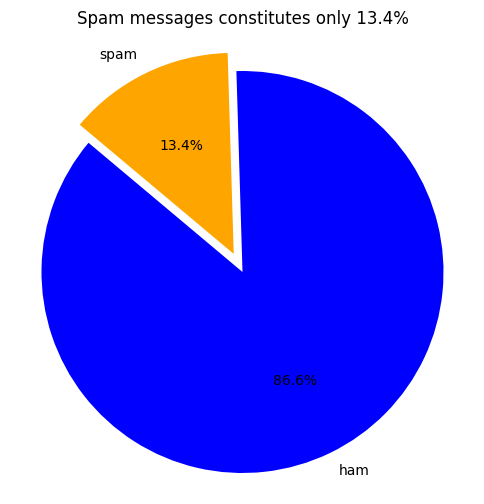

In [50]:
# display pie chart
labels = target_col.index
sizes = target_col['count']
colors = ['blue', 'orange']
explode = (0, 0.1) 

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Spam messages constitutes only 13.4%')
plt.show()


<b>Comment</b>: 
- As the proportion between spam and ham is not even (13.4 vs 86.6), the imbalanced distribution should be done during the modeling process to avoid bias in the model and impact on the model's evaluation.
- The model can be biased towards the majority class so it may not perform well when predicting the minority class, resulting in high false negatives (type II errors).
- When the categories in the target variable are imbalanced, evaluation metrics may not be accurate as they cannot refkect the effectiveness of the model in detecting minority class.
- For this reasons, an experiment on different resampling techniques may be advantageous for dealing with the imbalance issue.

In [51]:
# check missing values
(data.isna().sum() * 100).reset_index().rename(columns={'index':'column', 0: 'count'})

,column,count
0,status,0
1,text,0


**Comment**: As there are no missing values in the dataset, no need for data imputation or record removal.

In [52]:
# # build class for cleaning text
# class TextCleaner(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         def clean_text(text):
#             text = text.lower()  
#             text = re.sub(r'\d+', '', text)
#             text = re.sub(r'\b\d+\b', '', text)  
#             text = re.sub(r'http\S+|www\S+', '', text)  
#             text = re.sub(r'[^a-zA-Z\s]', '', text)  
#             text = re.sub(r'\s+', ' ', text).strip()  
#             return text
#         return X.apply(clean_text)

In [53]:
# build class for cleaning text
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, list):
            # Handle the case where X is a list of texts
            return [self.clean_text(text) for text in X]
        elif isinstance(X, pd.Series):
            # Handle the case where X is a pandas Series
            return X.apply(self.clean_text)
        elif isinstance(X, str):
            # Handle the case where X is a single string
            return self.clean_text(X)
        else:
            raise ValueError("Unsupported input!")

    def clean_text(self, text):
        text = text.lower()  
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\b\d+\b', '', text)  
        text = re.sub(r'http\S+|www\S+', '', text)  
        text = re.sub(r'[^a-zA-Z\s]', '', text)  
        text = re.sub(r'\s+', ' ', text).strip()  
        return text


**Comment**: 
- The custom transformer cleans raw text in the dataset into cleaner one. 
- First, the raw text will be converted into lowercase. Converting text into lowercase is beneficial to regularize them into the same lettercase. This is necessary because capital letters in English are only used mostly in the first letter in a sentence and proper nouns. 
- Second, numbers (`\d+`) will be removed (replaced them using nothing `''`) by using regular expression pattern. As TF-IDF will score word-types (vocabulary) based on their frequencies, different numbers will pose a challenge for the ML model. For example, if in a message contains two numbers, let's say 200 and 8, these numbers will be two different columns along with their frequencies.
- Third, URL removal is performed. URL is removed to reduce noise and focus more on textual content. Incorporating URLs in the analysis will be less efficient as there will be a different column assigned for every unique URL.
- Fourth, punctuation marks will be discarded from the text. These elements do not contribute much to the textual content.
- Last, extra-spaces are also deleted. 

In [54]:
# check the dataset
data.iloc[1:10, ]

,status,text
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [55]:
# specify features and target 
X = data['text']
y = data['status'].apply(lambda x: 1 if x == 'spam' else 0)

# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"The feature consists of {X_train.shape[0]} rows or {round(X_train.shape[0]/len(data)*100, 2)}% of the total data.")
print(f"The feature consists of {X_test.shape[0]} rows or {round(X_test.shape[0]/len(data)*100, 2)}% of the total data.")

The feature consists of 4457 rows or 79.99% of the total data.
The feature consists of 1115 rows or 20.01% of the total data.


**Comment**: 80% of the data will be used as the training set and the rest is used as the test set.

In [56]:
# pipeline 1: logistic regression
logistic_regression = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=2000)) 
])

# pipeline 2: naive bayes
naive_bayes = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', MultinomialNB())  
])

# pipeline 3: svm
svm = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', SVC())  
])

# pipeline 4: random forest
random_forest = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier())
])

# pipeline 5: gradient boosting
gbm = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', GradientBoostingClassifier())  
])

# collect all pipelines, incl the algorithms
models = {
    'Logistic Regression': logistic_regression,
    'Naive Bayes': naive_bayes,
    'SVM': svm,
    'Random Forest': random_forest,
    'Gradient Boosting': gbm
}

**Comment**: 
- Model 1 is build using a logistic regression algorithm. This model exploits pipeline from the data cleaning as described above, feature extraction using `TfidfVectorizer` to convert individual words to TF-IDF scores. Afterwards, the result will be passed on to the logistic algorithm.
- Model 2 to Model 5 are also similar to the Model 1 in the sense that they also use the same text cleaning class and the same feature extraction technique. The main difference lies on the use of different algorithms, namely Naive Bayes, Support Vector Machine, Random Forest, and Gradient Boosting.
- These all pipelines are stored in a dictionary which will be used for data modeling in the next phase. 

In [57]:
# display tf-idf vectorization output
pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer())
])

# Fit and transform the data using the pipeline
tfidf_matrix = pipeline.fit_transform(X)

# Get feature names
feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()

# Convert the tf-idf matrix to a DataFrame for better readability
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names)

# Display the DataFrame
display(tfidf_df.head())

,aa,aah,aaooooright,aathilove,aathiwhere,ab,abbey,abdomen,abeg,aberdeen,...,zeros,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <b>3 Data Modeling</b>

Before executing the data modeling, I will recap the metrics for evaluating the classification model's performance. As previously mentioned in the introduction section, the chosen metric is F1. In general, F1 combines two other performance metrics, namely precision and recall.
- **Precision**: This metrics evaluates accuracy of a model at identifying positive cases, and in this case, what is meant by "positive case" is a spam. $$\text{Precision} = \frac{TP}{TP + FP}$$
- **Recall**: This metrics measures the rate of true positives (e.g., actual spam, predicted as spam) from actual positive instances. $$\text{Recall}=\frac{TP}{TP + FN}$$
- As F1 is a combination between precision and recall, the F1 score can be measured as follows. $$F1=\frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

**Note**: Despite the metric of interest is F1, other metrics such as accuracy and area under the ROC curve (ROC-AUC) score will also be shown to complement the main metric.

In [58]:
dfs = []
# set up cross-val fold with 5 splits
cv = KFold(n_splits=5, shuffle=True, random_state=42)  

for name, model in models.items():
    # initialize lists to store metrics
    accuracy_list, recall_list, f1_list, precision_list, auc_list = [], [], [], [], []
    
    for train_index, test_index in cv.split(X):
        # split data into train and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)

        # append metrics for this fold
        accuracy_list.append(accuracy)
        recall_list.append(recall)
        f1_list.append(f1score)
        precision_list.append(precision)
        auc_list.append(auc)

    # calculate and store average metrics
    avg_accuracy = round(np.mean(accuracy_list), 4)
    avg_recall = round(np.mean(recall_list), 4)
    avg_f1score = round(np.mean(f1_list), 4)
    avg_precision = round(np.mean(precision_list), 4)
    avg_auc = round(np.mean(auc_list), 4)

    # create df for each model's metrics (averaged across folds)
    df = pd.DataFrame({
        'Model': [name],
        'Accuracy': [avg_accuracy],
        'Recall': [avg_recall],
        'Precision': [avg_precision],
        'AUC': [avg_auc],
        'F1 Score': [avg_f1score],
    })
    
    # append dfs
    dfs.append(df)

# display results
metrics_df = pd.concat(dfs, ignore_index=True)
display(metrics_df.sort_values(by='F1 Score', ascending=False))

,Model,Accuracy,Recall,Precision,AUC,F1 Score
2,SVM,0.9799,0.8665,0.9823,0.9320,0.9206
0,Logistic Regression,0.9770,0.9037,0.9243,0.9461,0.9134
3,Random Forest,0.9743,0.8084,1.0000,0.9042,0.8938
1,Naive Bayes,0.9693,0.9356,0.8502,0.9551,0.8908
4,Gradient Boosting,0.9627,0.8166,0.8971,0.9010,0.8541


**Comment** (pilih logistic regression)
- The table of modeling outputs summarizes performance reports on different models based on five metrics, namely accuracy, recall, precision, AUC, and F1. 
- Based on the table, the highest performing model is Naive Bayes with F1 score of 0.9242.

In [59]:
# set up parameter grids
param_grids = {
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga']
    },
    'Naive Bayes': {
        'model__alpha': [0.01, 0.1, 1, 10]
    },
    'SVM': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__kernel': ['linear', 'rbf', 'poly']
    },
    'Random Forest': {
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

In [60]:
# perform hyperparameter tuning and evaluate each model
dfs = []
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    
    # create a df for each model's metrics
    df = pd.DataFrame({
        'Model': [name],
        'Best Params': [grid_search.best_params_],
        'Accuracy': [round(accuracy, 4)],
        'Recall': [round(recall, 4)],
        'Precision': [round(precision, 4)],
        'AUC': [round(auc,4)],
        'F1 Score': [round(f1score, 4)]
    })
    
    # append the DataFrame to the list
    dfs.append(df)

# display results
metrics_df = pd.concat(dfs, ignore_index=True)
display(metrics_df.sort_values(by='F1 Score', ascending=False))

,Model,Best Params,Accuracy,Recall,Precision,AUC,F1 Score
0,Logistic Regression,"{'model__C': 10, 'model__solver': 'liblinear'}",0.9811,0.8981,0.9658,0.9464,0.9307
2,SVM,"{'model__C': 1, 'model__kernel': 'linear'}",0.9803,0.9045,0.9530,0.9486,0.9281
1,Naive Bayes,{'model__alpha': 0.1},0.9749,0.9299,0.8957,0.9561,0.9125
3,Random Forest,"{'model__max_depth': None, 'model__n_estimator...",0.9704,0.7898,1.0000,0.8949,0.8826
4,Gradient Boosting,"{'model__learning_rate': 0.2, 'model__n_estima...",0.9677,0.8153,0.9481,0.9040,0.8767


**Comment**
- The table displays the results of model tuning using grid search CV. This technique seeks to find the optimal hyperparameters for each model defined previously.
- As shown, Naive Bayes has the highest F1 score of 0.9428, offering the highest balance between precision and recall. 

## **4 Best Model and the Evaluation**
### **4.1 Model Selection: Multinomial Naive Bayes**

In [61]:
# store naive bayes as model (for simplification)
model = naive_bayes

# specify cv technique
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# perform cross-validation and store results
accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
recall_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
precision_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

# create df to store results for each fold
results_df = pd.DataFrame({
    'Fold': np.arange(1, 11),
    'Accuracy': accuracy_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'AUC': auc_scores,
    'F1 Score': f1_scores
})

# get mean and std
mean_scores = results_df.mean()
std_scores = results_df.std()

# combine into one df
mean_df = pd.DataFrame({
    'Fold': ['Mean'],
    'Accuracy': [mean_scores['Accuracy']],
    'Recall': [mean_scores['Recall']],
    'Precision': [mean_scores['Precision']],
    'AUC': [mean_scores['AUC']],
    'F1 Score': [mean_scores['F1 Score']]
})

std_df = pd.DataFrame({
    'Fold': ['Std'],
    'Accuracy': [std_scores['Accuracy']],
    'Recall': [std_scores['Recall']],
    'Precision': [std_scores['Precision']],
    'AUC': [std_scores['AUC']],
    'F1 Score': [std_scores['F1 Score']]
})

results_df = pd.concat([results_df, mean_df, std_df], ignore_index=True)

# display results
display(results_df)

,Fold,Accuracy,Recall,Precision,AUC,F1 Score
0,1,0.966368,0.932203,0.833333,0.993474,0.880000
1,2,0.975336,0.932203,0.887097,0.987562,0.909091
2,3,0.957399,0.949153,0.777778,0.994920,0.854962
3,4,0.961883,0.915254,0.818182,0.980861,0.864000
4,5,0.982063,0.983051,0.892308,0.998774,0.935484
5,6,0.964126,0.915254,0.830769,0.982438,0.870968
6,7,0.964126,0.966102,0.802817,0.980160,0.876923
7,8,0.984305,0.949153,0.933333,0.996628,0.941176
8,9,0.975281,0.898305,0.913793,0.986476,0.905983
9,10,0.973034,0.898305,0.898305,0.980504,0.898305


**Comment**:  Lorem ipsum

In [62]:
# specify param grid
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10]
}

# specify cv technique
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# perform grid search cv with cross-validation
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           cv=cv, 
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best model
best_model = grid_search.best_estimator_

# init lists to store results for each fold
accuracy_scores = []
recall_scores = []
precision_scores = []
roc_auc_scores = []
f1_scores = []

# perform cross-validation and collect scores for each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # fit the model on the training fold
    best_model.fit(X_train_fold, y_train_fold)
    
    # predict on the validation fold
    y_pred = best_model.predict(X_val_fold)
    
    # calculate evaluation metrics for the fold
    accuracy = accuracy_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred)
    roc_auc = roc_auc_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)
    
    # combine scores to respective lists
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    roc_auc_scores.append(roc_auc)
    f1_scores.append(f1)

# get mean andstd of each metric across folds
mean_accuracy = np.mean(accuracy_scores)
mean_recall = np.mean(recall_scores)
mean_precision = np.mean(precision_scores)
mean_roc_auc = np.mean(roc_auc_scores)
mean_f1 = np.mean(f1_scores)

std_accuracy = np.std(accuracy_scores)
std_recall = np.std(recall_scores)
std_precision = np.std(precision_scores)
std_roc_auc = np.std(roc_auc_scores)
std_f1 = np.std(f1_scores)

# create df to display results
results_dict = {
    'Fold': list(range(1, 11)) + ['Mean', 'Std'],
    'Accuracy': accuracy_scores + [mean_accuracy, std_accuracy],
    'Recall': recall_scores + [mean_recall, std_recall],
    'Precision': precision_scores + [mean_precision, std_precision],
    'AUC': roc_auc_scores + [mean_roc_auc, std_roc_auc],
    'F1 Score': f1_scores + [mean_f1, std_f1]
}
results_df = pd.DataFrame(results_dict)

# display result
display(results_df)

,Fold,Accuracy,Recall,Precision,AUC,F1 Score
0,1,0.977578,0.932203,0.901639,0.958350,0.916667
1,2,0.979821,0.898305,0.946429,0.945277,0.921739
2,3,0.975336,0.932203,0.887097,0.957058,0.909091
3,4,0.966368,0.898305,0.854839,0.937525,0.876033
4,5,0.979821,0.949153,0.903226,0.966824,0.925620
5,6,0.970852,0.881356,0.896552,0.932926,0.888889
6,7,0.968610,0.932203,0.846154,0.953182,0.887097
7,8,0.979821,0.915254,0.931034,0.952459,0.923077
8,9,0.979775,0.898305,0.946429,0.945267,0.921739
9,10,0.975281,0.864407,0.944444,0.928317,0.902655


**Comment**: Lorem ipsum

In [63]:
# print best model
print(best_model)

Pipeline(steps=[('cleaner', TextCleaner()), ('tfidf', TfidfVectorizer()),
                ('smote', SMOTE(random_state=42)),
                ('model', MultinomialNB(alpha=0.1))])


**Comment**: Data will firstly go through the text cleaning process using `TextCleaner`, and be converted into TF-IDF scoring via `TfidfVectorizer`. After its completion, the data will be resampled using synthetic minority over-sampling (SMOTE) technique to balance the target class (`spam` vs `ham`). And in the end, the preprocessed data will be fed to the Bernoulli Naive Bayes algorithm.

### **4.1 Model Selection: Linear Regression**

In [85]:
# store naive bayes as model (for simplification)
model = logistic_regression

# specify cv technique
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# perform cross-validation and store results
accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
recall_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
precision_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

# create df to store results for each fold
results_df = pd.DataFrame({
    'Fold': np.arange(1, 11),
    'Accuracy': accuracy_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'AUC': auc_scores,
    'F1 Score': f1_scores
})

# get mean and std
mean_scores = results_df.mean()
std_scores = results_df.std()

# combine into one df
mean_df = pd.DataFrame({
    'Fold': ['Mean'],
    'Accuracy': [mean_scores['Accuracy']],
    'Recall': [mean_scores['Recall']],
    'Precision': [mean_scores['Precision']],
    'AUC': [mean_scores['AUC']],
    'F1 Score': [mean_scores['F1 Score']]
})

std_df = pd.DataFrame({
    'Fold': ['Std'],
    'Accuracy': [std_scores['Accuracy']],
    'Recall': [std_scores['Recall']],
    'Precision': [std_scores['Precision']],
    'AUC': [std_scores['AUC']],
    'F1 Score': [std_scores['F1 Score']]
})

results_df = pd.concat([results_df, mean_df, std_df], ignore_index=True)

# display results
display(results_df)

,Fold,Accuracy,Recall,Precision,AUC,F1 Score
0,1,0.979821,0.915254,0.931034,0.996015,0.923077
1,2,0.982063,0.915254,0.947368,0.992817,0.931034
2,3,0.966368,0.847458,0.892857,0.994088,0.869565
3,4,0.979821,0.881356,0.962963,0.980423,0.920354
4,5,0.991031,0.966102,0.966102,0.999255,0.966102
5,6,0.975336,0.881356,0.928571,0.983401,0.904348
6,7,0.977578,0.915254,0.915254,0.978102,0.915254
7,8,0.991031,0.932203,1.000000,0.997898,0.964912
8,9,0.961798,0.830508,0.875000,0.979582,0.852174
9,10,0.964045,0.847458,0.877193,0.983007,0.862069


In [88]:
# specify param grid
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga']
}

# specify cv technique
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# perform grid search cv with cross-validation
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           cv=cv, 
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best model
best_model = grid_search.best_estimator_

# init lists to store results for each fold
accuracy_scores = []
recall_scores = []
precision_scores = []
roc_auc_scores = []
f1_scores = []

# perform cross-validation and collect scores for each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # fit the model on the training fold
    best_model.fit(X_train_fold, y_train_fold)
    
    # predict on the validation fold
    y_pred = best_model.predict(X_val_fold)
    
    # calculate evaluation metrics for the fold
    accuracy = accuracy_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred)
    roc_auc = roc_auc_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)
    
    # combine scores to respective lists
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    roc_auc_scores.append(roc_auc)
    f1_scores.append(f1)

# get mean andstd of each metric across folds
mean_accuracy = np.mean(accuracy_scores)
mean_recall = np.mean(recall_scores)
mean_precision = np.mean(precision_scores)
mean_roc_auc = np.mean(roc_auc_scores)
mean_f1 = np.mean(f1_scores)

std_accuracy = np.std(accuracy_scores)
std_recall = np.std(recall_scores)
std_precision = np.std(precision_scores)
std_roc_auc = np.std(roc_auc_scores)
std_f1 = np.std(f1_scores)

# create df to display results
results_dict = {
    'Fold': list(range(1, 11)) + ['Mean', 'Std'],
    'Accuracy': accuracy_scores + [mean_accuracy, std_accuracy],
    'Recall': recall_scores + [mean_recall, std_recall],
    'Precision': precision_scores + [mean_precision, std_precision],
    'AUC': roc_auc_scores + [mean_roc_auc, std_roc_auc],
    'F1 Score': f1_scores + [mean_f1, std_f1]
}
results_df = pd.DataFrame(results_dict)

# display result
display(results_df)

,Fold,Accuracy,Recall,Precision,AUC,F1 Score
0,1,0.986547,0.932203,0.964912,0.963518,0.948276
1,2,0.979821,0.915254,0.931034,0.952459,0.923077
2,3,0.984305,0.932203,0.948276,0.962226,0.940171
3,4,0.984305,0.915254,0.964286,0.955043,0.939130
4,5,0.982063,0.932203,0.932203,0.960934,0.932203
5,6,0.975336,0.881356,0.928571,0.935510,0.904348
6,7,0.982063,0.915254,0.947368,0.953751,0.931034
7,8,0.986547,0.915254,0.981818,0.956335,0.947368
8,9,0.975281,0.847458,0.961538,0.921138,0.900901
9,10,0.982022,0.864407,1.000000,0.932203,0.927273


In [89]:
# train the model
best_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# display result
print('Here are the evaluation metrics:')
print('Accuracy:', round(accuracy, 4))
print('Recall:', round(recall, 4))
print('F1 score:', round(f1score, 4))
print('Precision:', round(precision, 4))
print('ROC-AUC:', round(roc_auc, 4))
print('\nClassification Report:')
print(report)

Here are the evaluation metrics:
Accuracy: 0.9803
Recall: 0.8917
F1 score: 0.9272
Precision: 0.9655
ROC-AUC: 0.9898

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       957
           1       0.97      0.89      0.93       157

    accuracy                           0.98      1114
   macro avg       0.97      0.94      0.96      1114
weighted avg       0.98      0.98      0.98      1114



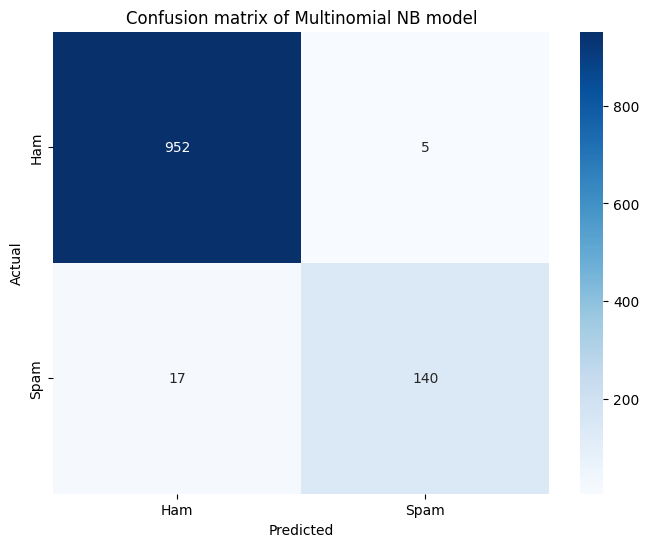

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of Multinomial NB model')
plt.show()

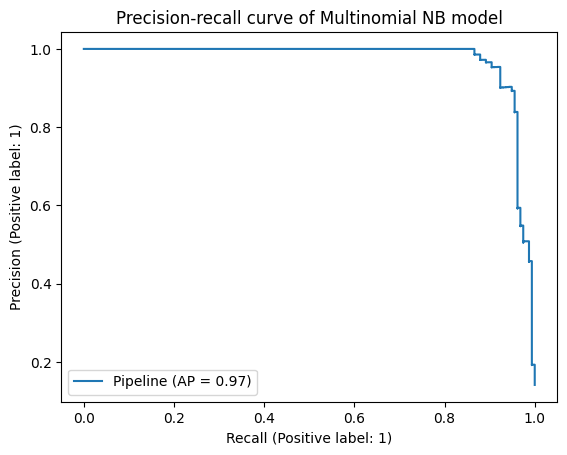

In [91]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(
   best_model, X_test, y_test)
plt.title('Precision-recall curve of Multinomial NB model', loc='center')
plt.show()

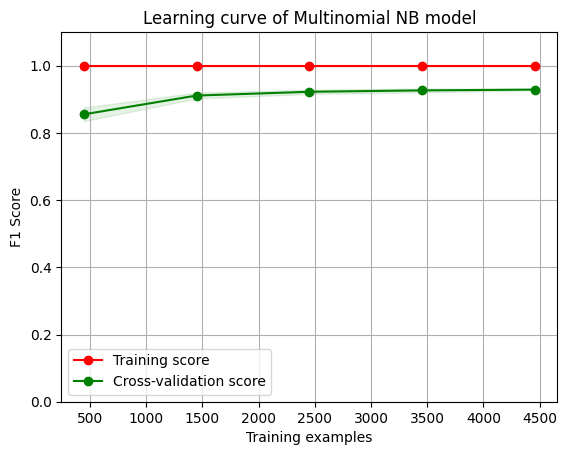

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring='f1', cv=5
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning curve of Multinomial NB model")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.grid()

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.ylim(0.0, 1.1)  
plt.show()

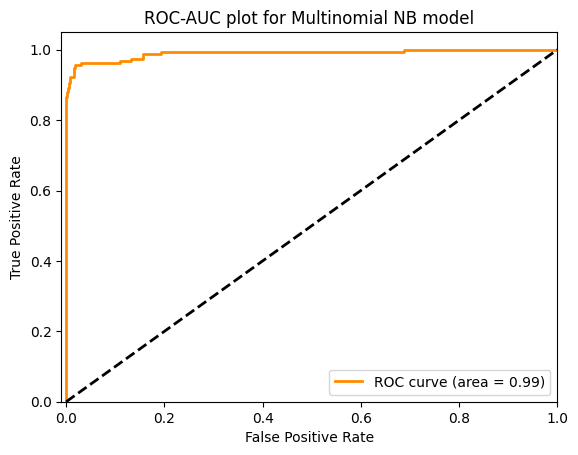

In [96]:
from sklearn.metrics import roc_curve, auc

# Get the best model
best_model = grid_search.best_estimator_

# Predict probabilities
y_pred_proba = best_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC plot for Multinomial NB model')
plt.legend(loc="lower right")
plt.xlim(-0.01, 1.0)
plt.show()

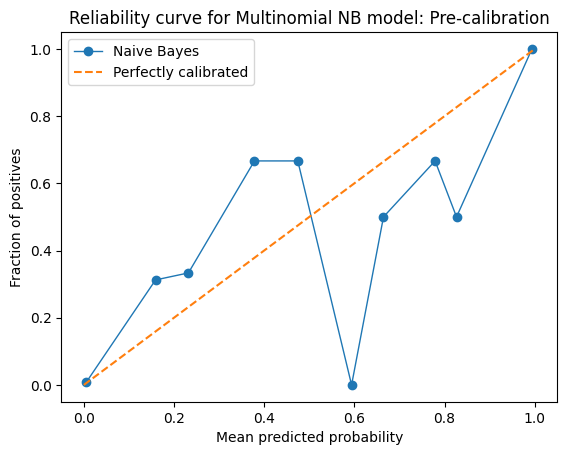

In [97]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# generate prediction and probability of prediction
y_pred_best_model = best_model.predict(X_test)
y_prob_best_model = best_model.predict_proba(X_test)[:, 1]

# make calibration curve plot
prob_true, prob_pred = calibration_curve(y_test, y_prob_best_model, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Naive Bayes')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability curve for Multinomial NB model: Pre-calibration')
plt.legend()
plt.show()

In [99]:
# calibrate model
calibrated_best_model= CalibratedClassifierCV(best_model, method='isotonic', cv='prefit')
calibrated_best_model.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('cleaner', TextCleaner()),
                                                 ('tfidf', TfidfVectorizer()),
                                                 ('smote',
                                                  SMOTE(random_state=42)),
                                                 ('model',
                                                  LogisticRegression(C=100,
                                                                     max_iter=2000,
                                                                     solver='liblinear'))]),
                       method='isotonic')

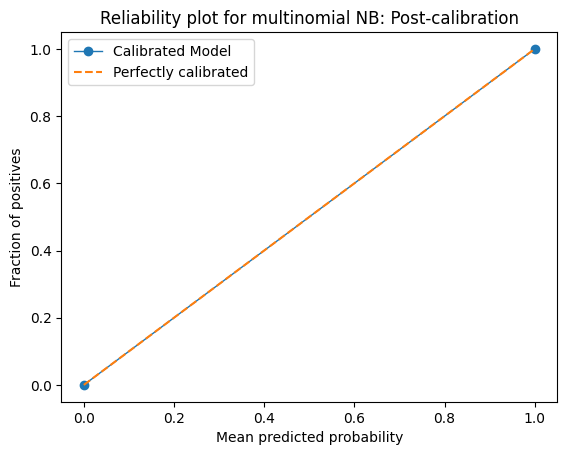

In [100]:
# generate new predicted probabilities
y_prob_calibrated = calibrated_best_model.predict_proba(X_train)[:, 1]
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_train, y_prob_calibrated, n_bins=10)

# plot reliability curve
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', linewidth=1, label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability plot for multinomial NB: Post-calibration')
plt.legend()
plt.show()

### **4.2 Best Model Evaluation** 

### **4.2.1 Classification Report**

In [64]:
# train the model
best_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# display result
print('Here are the evaluation metrics:')
print('Accuracy:', round(accuracy, 4))
print('Recall:', round(recall, 4))
print('F1 score:', round(f1score, 4))
print('Precision:', round(precision, 4))
print('ROC-AUC:', round(roc_auc, 4))
print('\nClassification Report:')
print(report)

Here are the evaluation metrics:
Accuracy: 0.9749
Recall: 0.9299
F1 score: 0.9125
Precision: 0.8957
ROC-AUC: 0.9763

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       957
           1       0.90      0.93      0.91       157

    accuracy                           0.97      1114
   macro avg       0.94      0.96      0.95      1114
weighted avg       0.98      0.97      0.98      1114



**Comment**: Lorem ipsum

#### **4.2.2 Confusion Matrix**

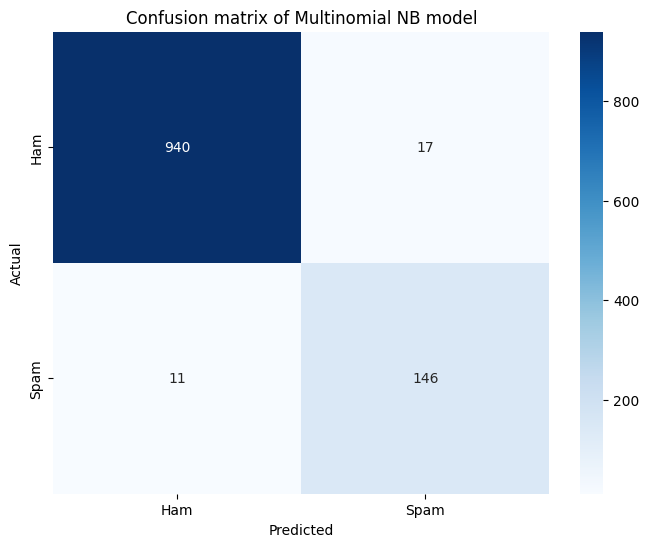

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of Multinomial NB model')
plt.show()

**Comment**:
- **True Positives (TP)** (actual Ham, prediction Ham): 957 "Ham" messages were correctly identified as "Ham".
- **False Negatives (FN)** (actual Spam, prediction Ham): 17 "Spam" messages were incorrectly labeled as "Ham".
- **False Positives (FP)** (actual Ham prediction Spam): There were 0 instances where "Ham" messages were wrongly marked as "Spam".
- **True Negatives (TN)** (actual Spam, prediction Spam): 140 spam messages were correctly classified as "Spam".

#### **4.2.3 Precision-Recall Curve** 

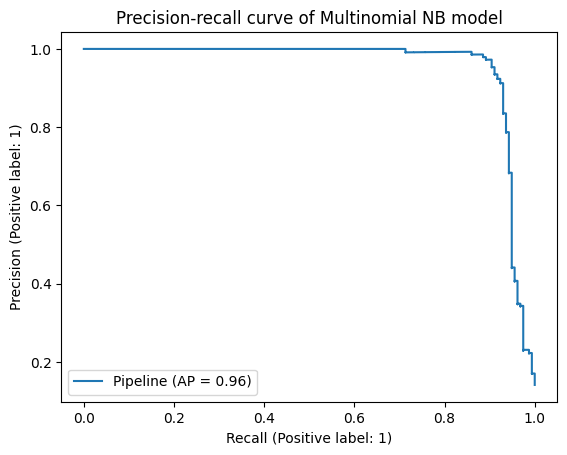

In [66]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(
   best_model, X_test, y_test)
plt.title('Precision-recall curve of Multinomial NB model', loc='center')
plt.show()

**Comment**
- Precision-recall curve displays the precision-recall trade-off of a model in different thresholds.
- The model starts with high accuracy (almost 1.0) but begins to make more mistakes when it tries to capture all positive cases. 
- The high average precision (AP) score indicates that despite this trade-off, the model is generally reliable in distinguishing between classes.

#### **4.2.4 Learning Curve Plot**

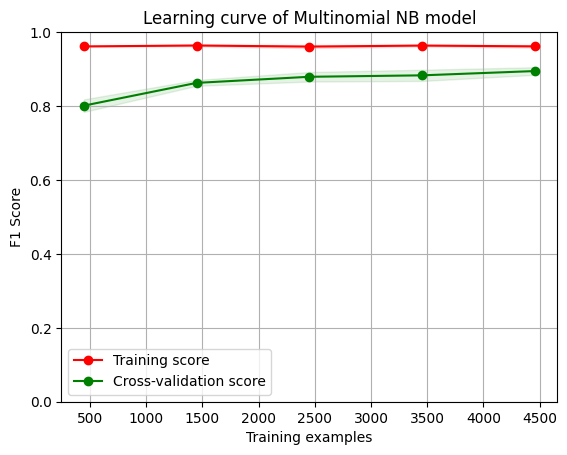

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score

train_sizes, train_scores, test_scores = learning_curve(
    naive_bayes, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring='f1', cv=5
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning curve of Multinomial NB model")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.grid()

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.ylim(0.0, 1.0)  
plt.show()

**Comment**: 
- The training score (red line) represents the performance of the best model (Bernoulli Naive Bayes) on the training data. The training score remains high from the start to the end regardless of how many training samples were added.
- The cross-balidation score (green line) shows how well the model performs on unseen data. Despite starting low, the score is getting higher as the number of training instance was added. The score got more stable around 1500 instances.
- As the both lines are stable and close to each other, adding more training data does not likely to increase the performance of the Bernoulli Naive Bayes model.

#### **4.2.5 ROC-AUC Curve**

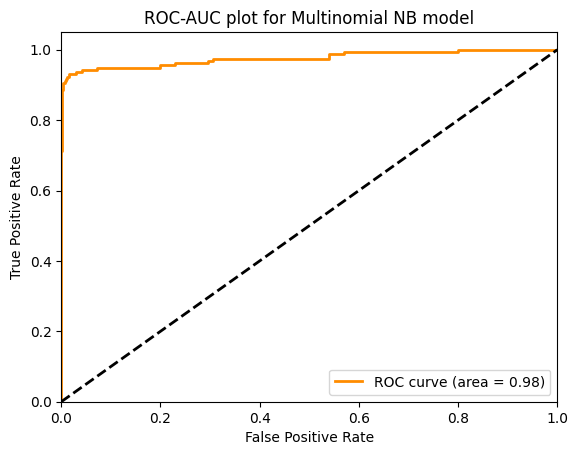

In [68]:
from sklearn.metrics import roc_curve, auc

# Get the best model
best_model = grid_search.best_estimator_

# Predict probabilities
y_pred_proba = best_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC plot for Multinomial NB model')
plt.legend(loc="lower right")
plt.show()

**Comment**
- The ROC-AUC plot displays a high true positive rate (TPR) with a low false positive rate (FPR), suggesting that the model correctly identifies a high number of positives while keeping false positives (FPs) low.
- As the closer the AUC score to 1.0, the better performance a model is, the plot then indicates model is performing very well in terms of ROC-AUC, which is a strong indicator of its ability to classify messages accurately as "Spam" or "Ham".

#### **4.2.6 Reliability Curve**

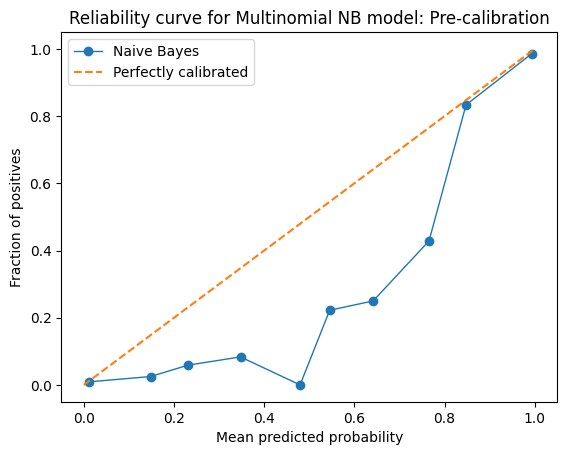

In [69]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# generate prediction and probability of prediction
y_pred_best_model = best_model.predict(X_test)
y_prob_best_model = best_model.predict_proba(X_test)[:, 1]

# make calibration curve plot
prob_true, prob_pred = calibration_curve(y_test, y_prob_best_model, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Naive Bayes')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability curve for Multinomial NB model: Pre-calibration')
plt.legend()
plt.show()

**Comment**
- Before calibration, the model’s confidence in its predictions was not aligned with the actual likelihood of messages being spam (dashed diagonal line), which could lead to misclassification.
- For this reason, this model needs a calibration so that the model's probability (or confidence) of prediction can be more reliable and more accurate. 

In [82]:
# calibrate model
calibrated_best_model= CalibratedClassifierCV(best_model, method='isotonic', cv='prefit')
calibrated_best_model.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('cleaner', TextCleaner()),
                                                 ('tfidf', TfidfVectorizer()),
                                                 ('smote',
                                                  SMOTE(random_state=42)),
                                                 ('model',
                                                  MultinomialNB(alpha=0.1))]),
                       method='isotonic')

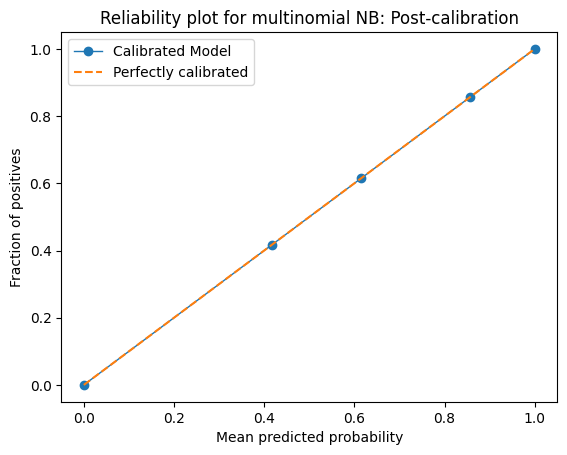

In [83]:
# generate new predicted probabilities
y_prob_calibrated = calibrated_best_model.predict_proba(X_train)[:, 1]
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_train, y_prob_calibrated, n_bins=10)

# plot reliability curve
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', linewidth=1, label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability plot for multinomial NB: Post-calibration')
plt.legend()
plt.show()

**Comment**
- As the blue line (NB's probabilities of predictions) is close to the orange one (perfect predictions), the model's predictions are reasonably accurate.

In [84]:
# make predictions with the model
y_pred_best_model = calibrated_best_model.predict(X_test)
y_prob_best_model = calibrated_best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_best_model))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       957
           1       0.97      0.90      0.93       157

    accuracy                           0.98      1114
   macro avg       0.98      0.95      0.96      1114
weighted avg       0.98      0.98      0.98      1114



**Comment**
- The precision scores for both class 0 (ham) and 1 (spam) show that the model made no errors when identifying both classes.
- The recall score for class 1 (spam) is slightly below the class 0 (ham), indicating the model missed 2% of spam messages (n = 3 out of 150).
- As the values are almost or equal to 1, the F1 scores indicates excellent performance. 

### **4.2 Best Model Evaluation**

## **5 Model Explanation**

In [73]:
# check X_test and y_test
test_instance = pd.DataFrame({'X_test': X_test, 
                              'y_test': y_test})
test_instance.iloc[10:15, :]

,X_test,y_test
77,I like you peoples very much:) but am very shy...,0
94,Havent planning to buy later. I check already ...,0
98,Hi. Wk been ok - on hols now! Yes on for a bit...,0
114,"Wa, ur openin sentence very formal... Anyway, ...",0
116,You are a winner U have been specially selecte...,1


## **5.1 Test for Class 0 (Not Spam/Ham)**

In [74]:
# check text in row 11
test_instance['X_test'].iloc[11]

'Havent planning to buy later. I check already lido only got 530 show in e afternoon. U finish work already?'

In [75]:
# check predicted probability for instance 11
calibrated_best_model.predict_proba(test_instance['X_test'])[:,1][11]

0.0

**Comment** (<span style='color:red;font-weight:bold'>GANTI</span>)
- Two code blocks above are used to see instances and predicted probability of the selected email.
- As can be seen, the status is a spam and the probability of model's prediction (similar to confidence score) is 1.0, meaning that the probability of the model is 100%.
- Now let us see how the model works using LIME (**L**ocal **I**nterpretable **M**odel-agnostic **E**xplanations ). 
    - This explainer helps in explaining why the model made a specific prediction by highlighting the influence of each feature. 
    - In this case, the feature is each word extracted from the email (column `text`).

In [76]:
# predict probabilities
y_pred_proba = calibrated_best_model.predict_proba(test_instance['X_test'])[:, 1]

# init LIME text explainer
explainer = LimeTextExplainer(class_names=['Ham', 'Spam'])

# explain instance idx 11
exp = explainer.explain_instance(test_instance['X_test'].iloc[11], calibrated_best_model.predict_proba, num_features=50)

# display the explanation
exp.show_in_notebook(text=True)

**Comment**: 
- The LIME output highlights what the prediction of the model is, how big the prediction probability is, how much each feature (individual word) contributes to the prediction, and color-highlighted words according to the model's classification.
- As shown previously, the actual status of the message is a spam, and based on the LIME output, the model predicted the message as a spam with high probability (1.0).
- The output also displays that the majority of words such as "tones", "content", and "unsubscribe" are three words with the highest contributions to the message predicted as a spam.
- While remaining unclear for word "tones" and "content", the word "unsubscribe" is common in marketing messages, particularly those sent to promote a product or a service.

## **5.2 Test for Class 1 (Spam)**

In [77]:
# check instance idx
test_instance.iloc[14]

X_test    You are a winner U have been specially selecte...
y_test                                                    1
Name: 116, dtype: object

In [78]:
# predict probabilities
y_pred_proba = calibrated_best_model.predict_proba(test_instance['X_test'])[:, 1]

# init LIME text explainer
explainer = LimeTextExplainer(class_names=['Ham', 'Spam'])

# explain instance idx 14
exp = explainer.explain_instance(test_instance['X_test'].iloc[14], calibrated_best_model.predict_proba, num_features=50)

# display the explanation
exp.show_in_notebook(text=True)

**Comment**: Lorem ipsum

<h1 style='text-align:center;font-style:italic'>---End---</h1>

___

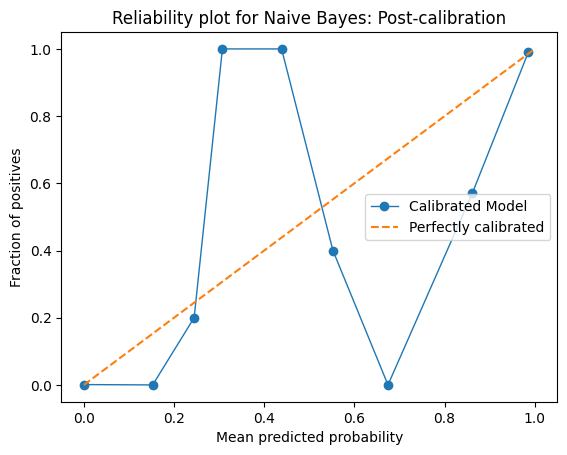

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       957
           1       0.94      0.91      0.93       157

    accuracy                           0.98      1114
   macro avg       0.96      0.95      0.96      1114
weighted avg       0.98      0.98      0.98      1114



In [79]:
# calibrate model
calibrated_best_model= CalibratedClassifierCV(best_model, method='sigmoid', cv='prefit')
calibrated_best_model.fit(X_train, y_train)

# generate new predicted probabilities
y_prob_calibrated = calibrated_best_model.predict_proba(X_train)[:, 1]
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_train, y_prob_calibrated, n_bins=10)

# plt.figure(figsize=(10, 7))
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', linewidth=1, label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability plot for Naive Bayes: Post-calibration')
plt.legend()
plt.show()

# make predictions with the model
y_pred_best_model = calibrated_best_model.predict(X_test)
y_prob_best_model = calibrated_best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_best_model))

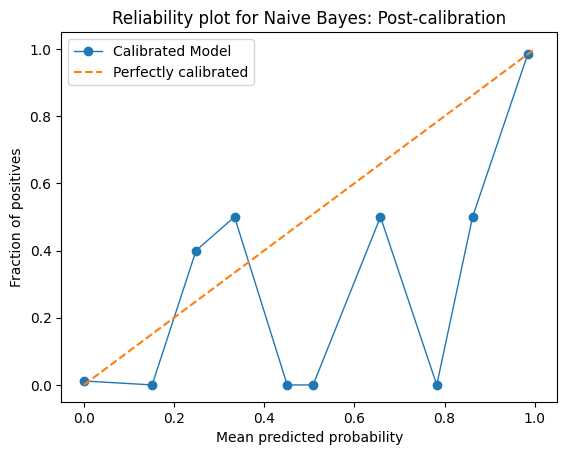

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       957
           1       0.94      0.91      0.93       157

    accuracy                           0.98      1114
   macro avg       0.96      0.95      0.96      1114
weighted avg       0.98      0.98      0.98      1114



In [80]:
# calibrate model
calibrated_best_model= CalibratedClassifierCV(best_model, method='sigmoid', cv='prefit')
calibrated_best_model.fit(X_train, y_train)

# generate new predicted probabilities
y_prob_calibrated = calibrated_best_model.predict_proba(X_test)[:, 1]
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_test, y_prob_calibrated, n_bins=10)

# plt.figure(figsize=(10, 7))
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', linewidth=1, label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability plot for Naive Bayes: Post-calibration')
plt.legend()
plt.show()

# make predictions with the model
y_pred_best_model = calibrated_best_model.predict(X_test)
y_prob_best_model = calibrated_best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_best_model))

**Comment**:
- The calibrated model’s line closely follows the perfectly calibrated line, indicating accurate predicted probabilities.
- This suggests that the model’s confidence in its predictions is appropriate, which is desirable in a probabilistic classifier.